# <center>EE 6770 Fall 2024: Homework 3</center>

1. __Write comments__ in the code to explain your thoughts.
2. __Important: Execute the codes and show the results__. 
3. __Do your own work.__ 

### Submission:
 * __Submit this notebook file and the pdf version__ - remember to add your name in the filename.
 * Deadline: 11:59 pm, 9/23 (Monday)

## Assignment Objectives:

In this assignment, you will implement a multi-layer neural network (with __at least two hidden layers__) to classify a spiral dataset. Building on the NumPy-based gradient descent algorithm we discussed in class, your goal is to train the neural network to meet the following performance benchmarks:

* __Achieve a prediction accuracy of at least 95%.__
* __Achieve a final loss of less than 0.01.__
  
This task expands on the insights you gained in Homework 2 from the __TensorFlow Playground__, where you experimented with various network architectures and hyperparameters for the spiral dataset classification. Apply your observations and follow the step-by-step instructions to complete this assignment.

### Import Tools

In [236]:
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

## <font color=blue>Section 1: Generate the Spiral Dataset</font>

In [237]:
def generate_spiral_data(n_points, noise=0.1):
    
    n = np.sqrt(np.random.rand(n_points, 1)) * 720 * (2*np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise
    
    return np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))), np.hstack((np.zeros(n_points), np.ones(n_points)))

### Write your code to generate 250 data points.

In [238]:
# Notation:
# X = input data,  Y = labelled target (0 or 1)

##  WRITE YOUR CODE:

# Using the aggrigate assignment to set X and Y
X, Y = generate_spiral_data(250)


### Plot the spiral data. The scrip is already written, so you only need to execute it and show the plot.

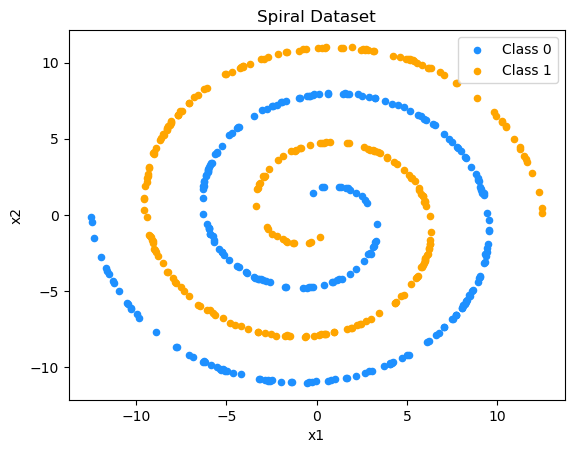

In [239]:
# Plot the dataset with custom colors: Dodger Blue for class 0, Orange for class 1

plt.scatter(X[Y == 0, 0], X[Y == 0, 1], color='dodgerblue', label='Class 0', s=20)
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color='orange', label='Class 1', s=20)

plt.title('Spiral Dataset')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()

### Normalize the two input features with respect to the mean and standard deviation.
### This is called `z-score normalization`, which helps to accelerate learning. 

In [240]:
def zscore_normalize(X):

    mu = np.mean(X, axis=0)        # find the mean of each column/feature          
                                    
    sigma  = np.std(X, axis=0)     # find the standard deviation of each column/feature            

    X = (X - mu) / sigma           # Normalize each column wrt its mean and std

    return X, mu, sigma

### Write codes to normalize the spiral dataset.

In [241]:
## WRITE YOUR CODE.
X, mu, sigma = zscore_normalize(X)
print("mu = ", mu, "sigma = ", sigma)


mu =  [-1.31450406e-16  7.19091453e-16] sigma =  [6.01746346 6.29545502]


### Activation Function Library
#### Those functions will be handy in calculating the forward and back propagation.

In [242]:
def sigmoid(z):
    a = 1 / (1 + np.exp(-z))
    return a

In [243]:
def dsigmoid(z):
    '''
    derivative of sigmoid function
    '''
    a = sigmoid(z)
    return a * (1 - a)

In [244]:
def relu(z):
    return np.maximum(z, 0)

In [245]:
def drelu(z):
    '''
    derivative of ReLU function
    '''
    return np.where(z < 0, 0, 1)

In [246]:
def dtanh(z):
    '''
    derivative of tanh function
    '''
    a = np.tanh(z)
    return 1 - a**2

## <font color=blue>Section 2: Set Up Neural Network Architecture</font>

### Neural Network Parameters

Here is where you specify the NN architecture of your choice, which shall include:
* Number of hidden layers
* Number of neurons in each of the hidden layer
* Number of neurons in the output layer (please set it as 1)

In [247]:
n = X.shape[1]   # number of input features
m = X.shape[0]   # number of samples
print(n, m)

2 500


In [248]:
## WRITE YOUR CODE

h1 = 8     # number of neurons in the hidden layer 1
h2 = 8     # number of neurons in the hidden layer 2
           # .....
out = 4    # number of neurons in the output layer 

## <font color=blue>Section 3: Run Gradient Descent to Optimize Weights</font>

In this section, you will use the `NumPy implementation` we covered in class to perform `forward propagation` and `backpropagation`, allowing you to compute the gradients and apply the gradient descent algorithm to find the optimal weights for your neural network.

__Note: Use the Sigmoid activation function for the output layer. For the hidden layers, you may choose the activation function that best fits your network design.__

### Set up hyperparameters

- __<font color='green'> Learning Rate</font>__: Experiment with different values of the learning rate. Start with a small value (e.g., 0.05) and gradually increase or decrease.
- __<font color='green'> Number of Iterations</font>__: Vary the number of iterations (epochs) for training. Begin with a moderate number (e.g., 10000) and adjust accordingly. 
- __<font color='green'> Random Initialization</font>__: Avoid initializing weights to zero. Randomize the initial values to prevent symmetries during training.

In [249]:
## WRITE YOUR CODE

alpha = 0.05    # learning rate
epoch = 10

## WRITE YOUR CODE. Random initialization of weights and biases

W1 = np.random.randn(h1, n) * 0.9
b1 = np.zeros((h1,1))
W2 = np.random.randn(h2, h1) * 0.9 
b2 = np.zeros((h2,1))
W3 = np.random.randn(out, h2) * 0.9
b3 = np.zeros((out, 1))

print(W1)
print(b1)

[[-0.82807489  1.03752831]
 [ 1.49721273  1.03521951]
 [-0.42225144 -1.32399926]
 [ 2.4830141   1.7709843 ]
 [-0.05124243  1.35099604]
 [ 0.39406845  0.08292017]
 [ 0.88586299  0.77536651]
 [ 2.03357243  0.66688156]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


### Run Gradient Descent

For each epoch, we will execute the following:

* __Forward propagation__
* __Calculate the cost function, $J(W,b)$, and store it in an array__
* __Backward propagation__
* __Update the weights & biases for each layer__

In [250]:
J = []      # An empty list for storing the loss function in each epoch

for i in range(epoch):

    # Forward progagation. Write your code.
    
    
    
    # Calculate and save the loss. Write your code.
    
    
    # Back progagation. Write your code.
    
    
    
    # Update weights and biases. Write your code
    
    
    # Display loss function periodically
    
    if i% math.ceil(epoch/20) == 0:
        print(f"{i:9d} {J[-1]:0.3e}")

IndexError: list index out of range

### Print the following outputs:
* #### Final loss function, $J$. <font color='red'>Is it less than 0.01?</font> 
* #### The first 10 elements of $A^{[L]}$ (the activation output at the Output Layer)

In [ ]:
## WRITE YOUR CODE to print the final loss function.



In [ ]:
## WRITE YOUR CODE to print the first 10 elements of A^L.



### Print the optimum weights.

In [ ]:
## WRITE YOUR CODES



### What are the predicted outputs, $\hat{Y}$?
#### Recall that, for binary classification, $\hat{y} = 1$, if $a^{[L]} \ge 0.5$ and $\hat{y} = 0$ otherwise.

In [ ]:
## WRITE YOUR CODE



## <font color=blue>Section 4: Performance Analysis</font>

#### <font color='green'>Prediction Accuracy</font> is obtained by comparing the labelled target, $Y$, with the predicted output, $\hat{Y}$. It is defined as $\frac{\text{Total Number of Errors}}{\text{Total Number of Samples}}$.

In [ ]:
## WRITE YOUR CODE



### Execute the following script to plot the Loss Function vs. Epoch.

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(J, color='orange')

plt.title('Loss Function vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss Function')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

## <font color=blue>Extra Credit: visualize the decision boundary</font>
* The following script plots the decision boundary using the given weights and biases. It is designed for a 3-layer neural network, but you can easily modify the code to suit your own network architecture.
* You will need to implement the `forward_propagation` function based on your network's structure.
* It’s also a great learning opportunity to generate this plot at different stages of training (e.g., after 1000 epochs, 5000 epochs, and 10,000 epochs) to observe how the decision boundary evolves as the model learns and improves its classification.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a meshgrid of points
def create_meshgrid(X, h=0.02):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# Forward propagation through the network
def forward_propagation(X, W1, b1, W2, b2, W3, b3):

    ## WRITE YOUR CODE
    

# Predict function that computes output for each point in the meshgrid
def predict_on_grid(xx, yy, W1, b1, W2, b2, W3, b3):
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]  # Combine the grid points into a shape for input
    Z1, A1, Z2, A2, Z3, A3 = forward_propagation(grid_points, W1, b1, W2, b2, W3, b3)
    predictions = (A3 >= 0.5).astype(int)  # Convert sigmoid output to binary class (0 or 1)
    
    return predictions.reshape(xx.shape)

# Plot the decision boundary
def plot_decision_boundary(X, y, W1, b1, W2, b2, W3, b3):
    xx, yy = create_meshgrid(X)
    Z = predict_on_grid(xx, yy, W1, b1, W2, b2, W3, b3)
    
    # Plot the contour map for decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    
    # Plot the original data points
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='dodgerblue', label='Class 0', s=12)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='orange', label='Class 1', s=12)
    plt.legend()
    plt.title('Decision Boundary Visualization')
    plt.show()

# Example usage after training your neural network
plot_decision_boundary(X, Y, W1, b1, W2, b2, W3, b3)
